In [488]:
import george
from george import kernels
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import emcee
from corner import corner

In [489]:
def fake_data(params, N, rng=(-10, 10)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.00005 + 0.001 * np.random.randint(N)
    yerr += 0.1 * abs(yerr * np.random.normal(0, 5, N))
    return t, y, yerr

In [562]:
from george.modeling import Model as mgo

class Model(mgo):
    parameter_names = ("amp", "location", "log_sigma2")
    
    def get_value(self, t): 
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

In [588]:
class PolynomialModel(mgo): 
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b + 
               self.amp * np.exp(-0.5*(t-self.location)**2 * np.exp(-self.log_sigma2)))

In [589]:
true = dict(amp=-1, location=0, log_sigma2=np.log(0.4))

In [590]:
t, y, yerr = fake_data(true, 50)
yerr *= 0.8

In [566]:
yerr += np.random.normal(0, 1e-11, len(t))

In [567]:
y += np.random.normal(0, 0.1, len(t))

In [568]:
y += 2*np.linspace(0, 1, len(t))

<ErrorbarContainer object of 3 artists>

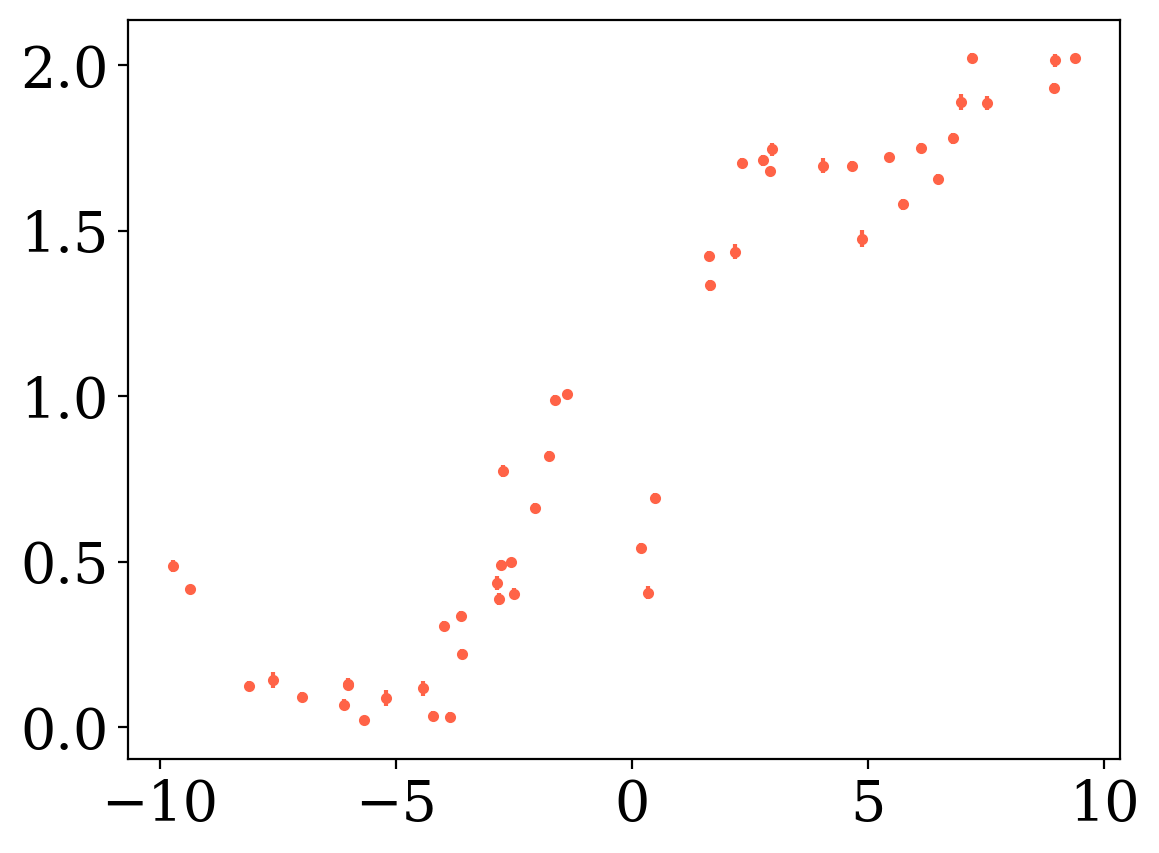

In [569]:
plt.errorbar(t, y, yerr, fmt='.', color='tomato')


In [549]:
from scipy.optimize import minimize

#np.random.seed(42)
#nll = lambda *args: -log_likelihood(*args)
#initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
#soln = minimize(nll, initial, args=(x, y, yerr))

In [573]:
i0 = dict(m=0, b=1, amp=-1, location=0, siglog_sigma2=np.log(0.4))

In [579]:
kwargs = dict(**i0)
kwargs["bounds"] = dict(m=(-np.inf, np.inf), 
                            b=(-np.inf, np.inf), 
                            amp=(-np.inf, np.inf), 
                            location=(-2,2),
                            log_sigma2=(-np.inf, np.inf)) # adding boundaries to the location...

mean_model = PolynomialModel(**kwargs)

#TODO: what kernel and what scale length to choose?                        
gp = george.GP(np.var(y) * kernels.Matern32Kernel(5), mean=mean_model)

gp.compute(t, yerr)
init = gp.get_parameter_vector()

In [580]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [586]:
bnds = ((0, None), (0, None), (0, None), (-2, 2), (None, None))

In [587]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), bounds=bnds)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

ValueError: length of x0 != length of bounds

In [555]:
tt = np.linspace(min(t), max(t), 1000)
yy, varr = gp.predict(y, tt, return_var=True)

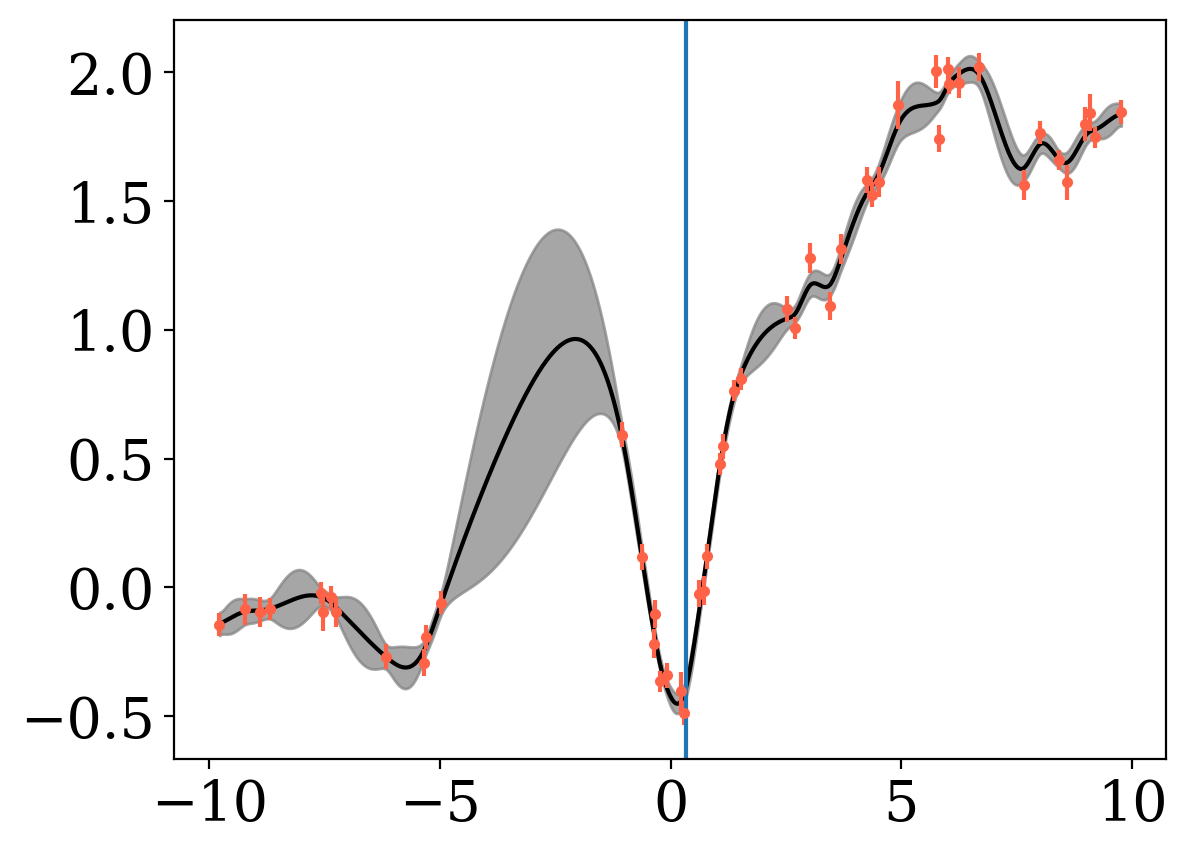

In [556]:
plt.plot(tt, yy, color='k')
plt.fill_between(tt, yy-np.sqrt(varr), yy+np.sqrt(varr), color='gray', alpha=0.7)
plt.errorbar(t, y, yerr, fmt='.', color='tomato')
plt.axvline(0.32819268)